# Inception's Dense Cropping (144-Crop)

Google's Inception architecture ([Going deeper with convolutions](https://arxiv.org/abs/1409.4842)) uses a more dense cropping technique during test-time, resulting in 144 crops instead of the 10 crops and 5 crops techniques available in `torchvision.transforms`. The crops are generated through the following process:

> During testing, we adopted a more aggressive cropping approach than that of Krizhevskyet al. [9]. Specifically, we resize the image to 4 scales where the shorter dimension (height or width) is 256, 288, 320 and 352 respectively, take the left, center and right square of these resized images (in the case of portrait images, we take the top, center and bottom squares). For each square, we then take the 4 corners and the center 224×224 crop as well as the square resized to 224×224, and their mirrored versions. This results in 4×3×6×2 = 144 crops per image. A similar approach was used by Andrew Howard [8] in the previous year’s entry, which we empirically verified to perform slightly worse than the proposed scheme. We note that such aggressive cropping may not be necessary in real applications, as the benefit of more crops becomes marginal after a reasonable number of crops are present (as we will show later on).

In [ ]:
!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
!pip3 install git+https://github.com/aleju/imgaug
!pip3 install skimage

In [3]:
from PIL import Image
from torchvision.transforms import Resize, TenCrop

def _dense_crop(img, size, resizes=(256, 288, 320, 352)):
    resized = [Resize(size_)(img) for size_ in resizes]
    results = []
    for resized_img in resized:
        w, h = resized_img.size
        if w < h:
            t1 = resized_img.crop((0, 0, w, w))
            t2 = resized_img.crop((0, h/2 - w/2, w, h/2 + w/2))
            t3 = resized_img.crop((0, h-w, w, h))
        else:
            t1 = resized_img.crop((0, 0, h, h))
            t2 = resized_img.crop((w/2 - h/2, 0, w/2 + h/2, h))
            t3 = resized_img.crop((w-h, 0, w, h))

        for square in (t1, t2, t3):
            resized_square = Resize(size)(square)
            results.append(resized_square)
            results.append(resized_square.transpose(Image.FLIP_LEFT_RIGHT))
            results += TenCrop(size)(square)

    return results


class DenseCrop(object):
    def __init__(self, size, resizes):
        self.size = size
        self.resizes = resizes

    def __call__(self, img):
        return _dense_crop(img, self.size, self.resizes)

In [24]:
import torch
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from PIL import Image

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'

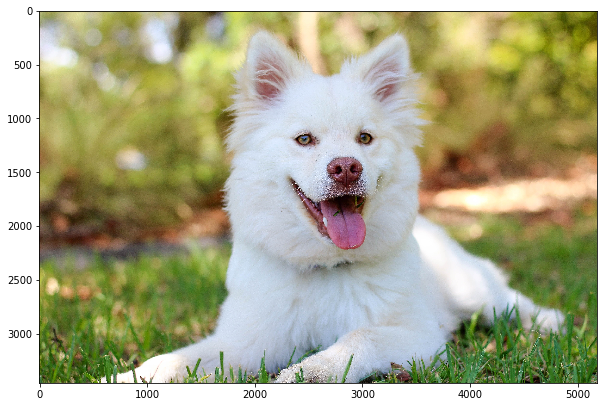

In [28]:
img = Image.open('../data/classification/dogs/1.jpg')
mpl.rcParams['figure.figsize'] = 10, 10
plt.imshow(img)

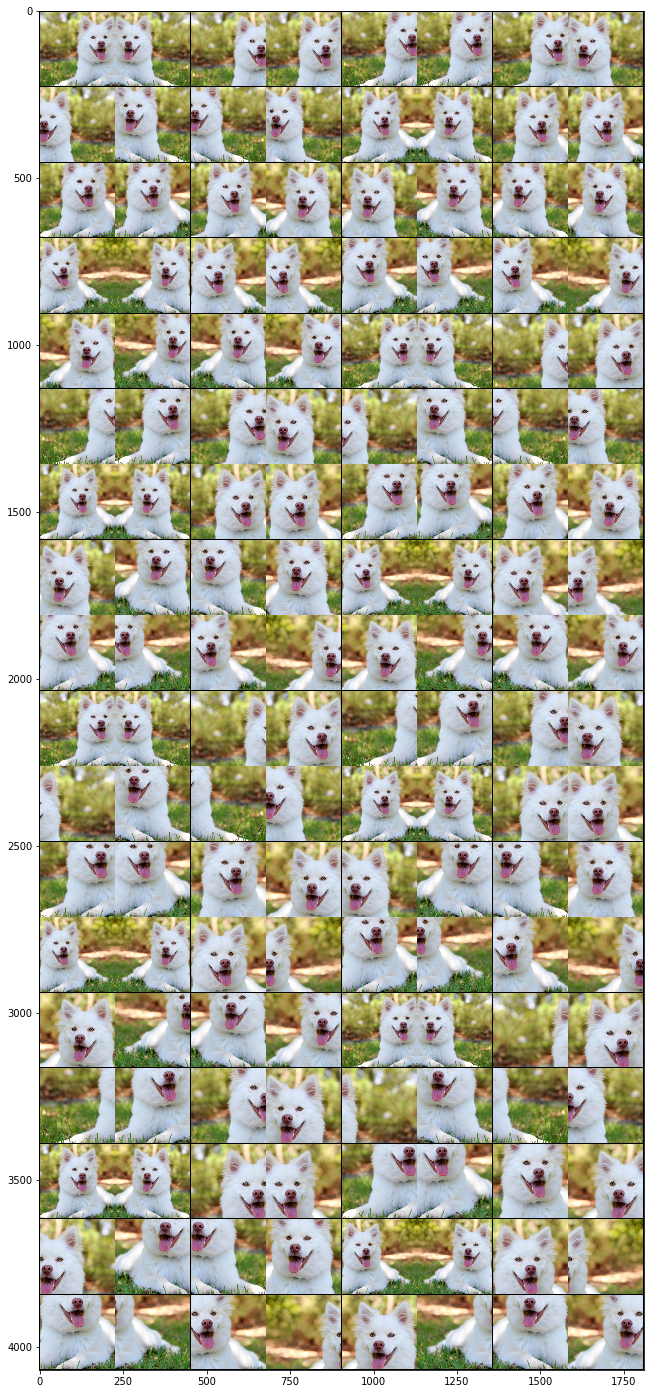

In [27]:
mpl.rcParams['figure.figsize'] = 20, 25
img = Image.open('../data/classification/dogs/1.jpg')
crops = DenseCrop(size=224, resizes=(256, 288, 320, 352))(img)
grid = make_grid(torch.stack([ToTensor()(crop) for crop in crops]))
plt.imshow(grid.numpy().transpose((1, 2, 0)))